In [19]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

#### Input (X): Sử dụng dữ liệu từ t-100 đến t để dự đoán giá trị Close tại bước t+1.
#### Target (y): Lấy giá trị Close tại thời điểm t+1 làm mục tiêu.     
#### LSTM sẽ sử dụng dữ liệu của 100 phút trước đó để dự đoán giá trị của phút tiếp theo.
#### Giá trị dự đoán là giá Close tại thời điểm t+1.

In [20]:
# import data2 as data_file

# X_train, X_test, y_train, y_test, scaler, data = data_file.splitData()

# # print(X_train[:5])
# # print(X_test[:5])

# print("Train size:", X_train.shape, "Test size:", X_test.shape, "Data size:", data.shape)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('./newfile.csv')

# Convert the 'Date' column to datetime and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Remove rows with NaN or inf values
data = data.dropna()  # Drop rows containing NaN
data = data.replace([np.inf, -np.inf], np.nan).dropna()  # Remove inf/-inf

scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Time steps
timesteps = 100

X = []
y = []

close_index = data.columns.get_loc('Close')

for i in range(timesteps, len(scaled_data)):
    X.append(scaled_data.iloc[i - timesteps:i].values)
    y.append(scaled_data.iloc[i, close_index])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [22]:
for each in y_test:
  print(each)

0.8018859951906254
0.7937944568160447
0.7930459414994679
0.795772205497089
0.7943371852970529
0.7964916362742365
0.7990088208469217
0.794873328599321
0.7936144619305328
0.7972105182864926
0.7990088208469217
0.7964916362742365
0.7979228151200122
0.8004476824012201
0.7975705080575164
0.7954198984345933
0.7933806880853265
0.7875006722369964
0.7851629337849317
0.7855223747910589
0.7906653993856043
0.7896584158035509
0.7873206773514863
0.7928950311533836
0.7918161593701072
0.7921756003762344
0.7928516787266879
0.7968510772803654
0.794873328599321
0.7957359870140284
0.7932440456265084
0.7943338927076837
0.801522712830236
0.8072809028719075
0.8051264518947185
0.8076403438780346
0.8123158207821657
0.8141135745777
0.8148330053548491
0.8127109315064587
0.8115963900050165
0.8069209131008819
0.8042846465460194
0.8028606016438804
0.8019831265770101
0.8069209131008819
0.8044070211175711
0.8079964922947926
0.8095105346396867
0.8097980874445891
0.8058815523900336
0.8053026054259682
0.8065614720947565


In [23]:
X_train.shape[2]

6

In [27]:
model = Sequential()

model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Loại bỏ ngẫu nhiên 10% số nút trong quá trình huấn luyện để giảm overfitting.
model.add(Dropout(0.1))

# return_sequences=False nghĩa là tầng này chỉ giữ lại trạng thái cuối cùng của chuỗi (last hidden state).
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.1))

# Tầng đầu ra, dự đoán giá trị Close tại thời điểm t+1.
model.add(Dense(1))

# Compile mô hình
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

print(model.summary())

# Huấn luyện mô hình
# Epoch: Số lần toàn bộ dữ liệu huấn luyện được duyệt qua (50 lần trong mô hình này).
# Batch size: Số mẫu trong một lô dữ liệu được đưa vào mô hình cùng lúc (32 mẫu).
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100, 128)          69120     
                                                                 
 dropout_8 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 118593 (463.25 KB)
Trainable params: 118593 (463.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5

In [ ]:
model.save('keras_model.h5')

c:\Users\LT MSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
y_pred = model.predict(X_test)

print("Shape of predictions:", y_pred.shape)

52/52 [==============================] - 2s 27ms/step
Shape of predictions: (1655, 1)


In [ ]:
# Chuyển đổi giá trị dự đoán và thực tế về thang đo gốc
y_pred_original = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], data.shape[1] - 1))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))), axis=1))[:, 0]

In [ ]:
mse_original = mean_squared_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mse_original)
mae_original = mean_absolute_error(y_test_original, y_pred_original)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE Original: {mse_original}")
print(f"RMSE Original: {rmse_original}")
print(f"MAE Original: {mae_original}")

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

MSE Original: 1.825099360860332
RMSE Original: 1.3509623832144002
MAE Original: 1.2063325450705413
MSE: 0.002360581595346169
RMSE: 0.04858581681258605
MAE: 0.04338437011873208


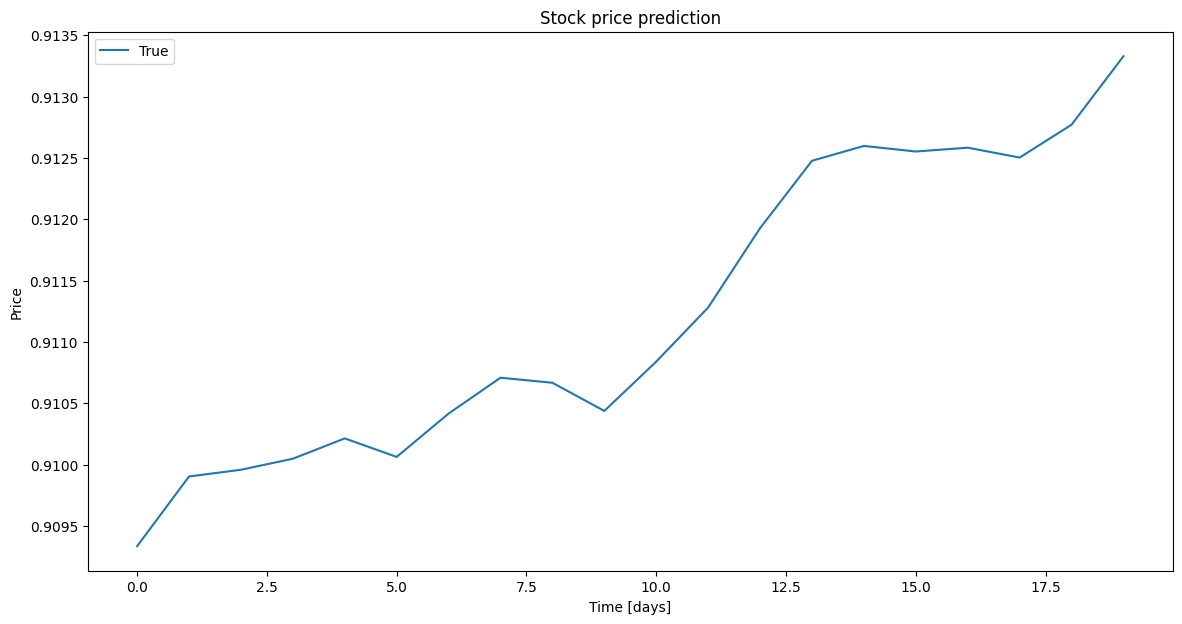

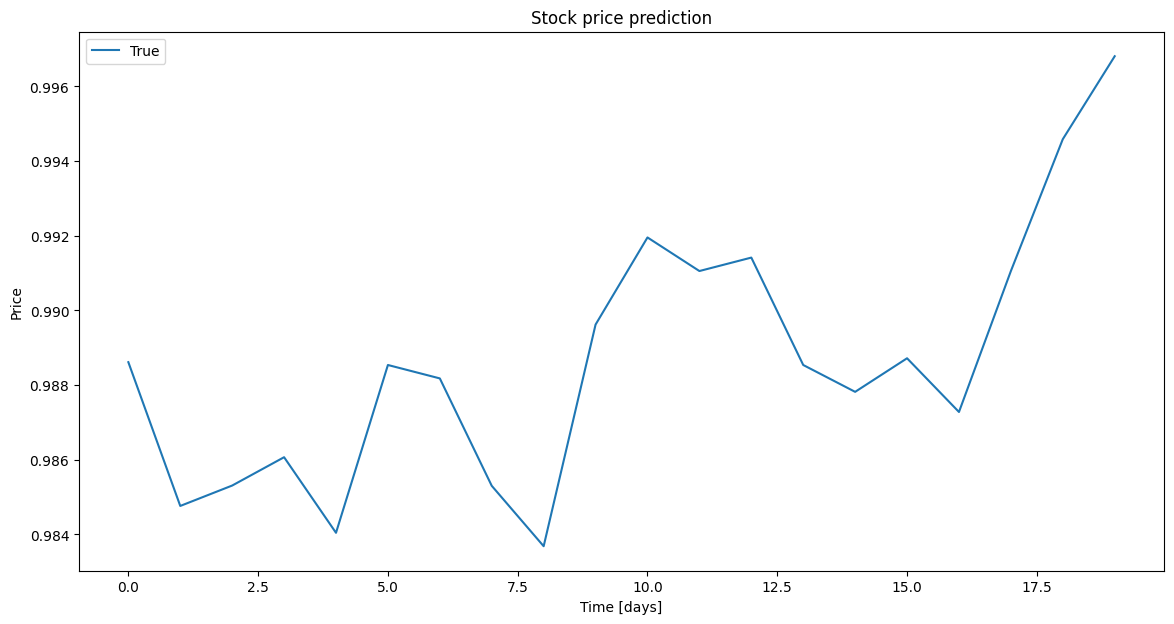

In [ ]:
y_pred = y_pred.reshape(-1, 1)

y_pred_original = y_pred_original.reshape(-1, 1)

# y_pred last 20 rows
a = y_pred[-20:]
# y_test last 20 rows
b = y_test[-20:]

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))
plt.plot(a, label='True')
# plt.plot(b, label='Predict')
plt.title("Stock price prediction")
plt.xlabel("Time [days]")
plt.ylabel("Price")
plt.legend(loc='best')
plt.show()

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))
plt.plot(b, label='True')
# plt.plot(b, label='Predict')
plt.title("Stock price prediction")
plt.xlabel("Time [days]")
plt.ylabel("Price")
plt.legend(loc='best')
plt.show()


[253.36210632 253.25500488 253.27020264 253.29130554 253.23500061
 253.36000061 253.3500061  253.27000427 253.2250061  253.3901062 ]
          Thời gian  Dự đoán (Predicted)  Giá trị thật (Actual)
2024-12-18 16:33:00             0.909335               0.988614
2024-12-18 16:34:00             0.892051               0.984762
2024-12-18 16:35:00             0.880606               0.985309
2024-12-18 16:36:00             0.874607               0.986068
2024-12-18 16:37:00             0.870243               0.984043
2024-12-18 16:38:00             0.864262               0.988538
2024-12-18 16:39:00             0.856672               0.988179
2024-12-18 16:40:00             0.848663               0.985302
2024-12-18 16:41:00             0.840993               0.983684
2024-12-18 16:42:00             0.833693               0.989621


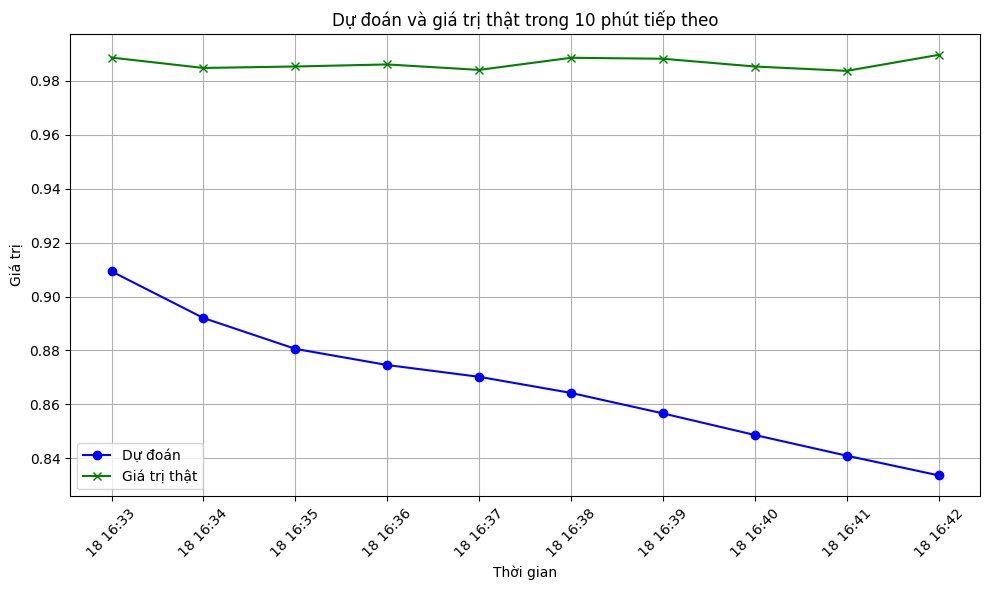

In [ ]:
# Kiểm tra và xử lý index thời gian trong data
def prepare_time_index(data):
    if not isinstance(data.index, pd.DatetimeIndex):
        if 'time' in data.columns:  # Nếu có cột 'time' chứa thời gian
            data['time'] = pd.to_datetime(data['time'])  # Chuyển sang datetime
            data.set_index('time', inplace=True)  # Đặt cột 'time' làm index
        else:
            raise ValueError("DataFrame `data` không chứa thời gian hoặc không có index thời gian.")
    return data

# Hàm lấy chỉ số gần nhất cho một thời gian nhập vào
def get_test_record_by_datetime(input_datetime, time_index):
    time_diff = (time_index - input_datetime).total_seconds()  # Tính chênh lệch thời gian
    closest_time_index = np.argmin(np.abs(time_diff))  # Tìm chỉ số có sự khác biệt nhỏ nhất
    return closest_time_index

# Hàm dự đoán
def predict_future_from_last_20(data, X_test, y_test, model, scaler, num_minutes=10):
    # Chuẩn bị time index từ data
    data = prepare_time_index(data)
    time_index_test = data.index[-len(X_test):]  # Lấy index của tập X_test
    time_index_test = time_index_test.tz_localize(None)  # Loại bỏ timezone nếu có

    # Chọn dòng bắt đầu dự đoán: cách dòng cuối 20 dòng
    start_index = len(X_test) - 20
    input_datetime = time_index_test[start_index]

    # Lấy index tương ứng với thời gian nhập vào
    index_for_input = get_test_record_by_datetime(input_datetime, time_index_test)

    # Lấy X_current tương ứng với chỉ số này
    X_current = X_test[index_for_input]

    # Khởi tạo danh sách kết quả
    future_predictions = []
    actual_values = []

    # Dự đoán liên tục trong num_minutes phút
    for i in range(num_minutes):
        # Dự đoán giá trị tiếp theo
        next_pred = model.predict(X_current.reshape(1, X_current.shape[0], X_current.shape[1]), verbose=0)[0, 0]

        # Lấy giá trị thực tế từ y_test
        actual_value = y_test[index_for_input + i] if index_for_input + i < len(y_test) else None

        

        # Thêm giá trị dự đoán và giá trị thực tế vào danh sách
        future_predictions.append(next_pred)
        actual_values.append(actual_value if actual_value is not None else np.nan)

        # Cập nhật đầu vào cho lần dự đoán tiếp theo
        X_current = np.roll(X_current, -1, axis=0)  # Lăn dữ liệu về bên trái
        X_current[-1] = np.array([next_pred] * X_current.shape[1])  # Thay thế giá trị cuối cùng bằng dự đoán mới

    # Chuyển đổi giá trị về thang đo gốc
    def inverse_transform(values):
        values_array = np.array(values).reshape(-1, 1)
        extended_array = np.zeros((len(values), X_test.shape[2]))
        extended_array[:, 0] = values_array[:, 0]
        return scaler.inverse_transform(extended_array)[:, 0]

    # Chuyển đổi giá trị thực tế và dự đoán về thang đo gốc
    actual_values_original = inverse_transform(actual_values)
    future_predictions_original = inverse_transform(future_predictions)
    
      # Tạo DataFrame để hiển thị các giá trị dự đoán và thực tế sacaled
    future_df = pd.DataFrame({
        "Thời gian": time_index_test[start_index:start_index + num_minutes],
        "Dự đoán (Predicted)": future_predictions,
        "Giá trị thật (Actual)": actual_values,
    })

    print(actual_values_original)

    # # Tạo DataFrame để hiển thị các giá trị dự đoán và thực tế
    # future_df = pd.DataFrame({
    #     "Thời gian": time_index_test[start_index:start_index + num_minutes],
    #     "Dự đoán (Predicted)": future_predictions_original,
    #     "Giá trị thật (Actual)": actual_values_original,
    # })

    # Hiển thị kết quả dự đoán
    print(future_df.to_string(index=False))

    # Vẽ biểu đồ kết quả
    plt.figure(figsize=(10, 6))
    plt.plot(future_df["Thời gian"], future_df["Dự đoán (Predicted)"], marker='o', label="Dự đoán", color='b')
    plt.plot(future_df["Thời gian"], future_df["Giá trị thật (Actual)"], marker='x', label="Giá trị thật", color='g')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị')
    plt.title('Dự đoán và giá trị thật trong {} phút tiếp theo'.format(num_minutes))
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Gọi hàm dự đoán
predict_future_from_last_20(data, X_test, y_test, model, scaler, num_minutes=10)

In [ ]:
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
print(X_test_df.tail(20))

           0         1         2         3         4         5         6    \
1635  0.938905  0.938905  0.934482  0.935436  0.937430  0.020668  0.943224   
1636  0.943224  0.943224  0.939079  0.939831  0.940309  0.039743  0.949697   
1637  0.949697  0.949697  0.947084  0.946693  0.944171  0.033895  0.950417   
1638  0.950417  0.950417  0.947804  0.951091  0.950843  0.020101  0.942145   
1639  0.942145  0.942145  0.945464  0.946165  0.951370  0.019330  0.943044   
1640  0.943044  0.943044  0.940245  0.943350  0.942942  0.024664  0.943584   
1641  0.943584  0.943584  0.939525  0.944757  0.944171  0.025277  0.940347   
1642  0.940347  0.940347  0.939525  0.942998  0.944171  0.037314  0.945382   
1643  0.945382  0.945382  0.944204  0.942998  0.942241  0.026811  0.956171   
1644  0.956171  0.956171  0.954644  0.948628  0.946454  0.033377  0.961522   
1645  0.961522  0.961522  0.959784  0.959887  0.957163  0.056891  0.969078   
1646  0.969078  0.969078  0.964363  0.964814  0.963132  0.031847

In [ ]:
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))
print(X_train_df.head(20))

         0         1         2         3         4         5         6    \
0   0.011760  0.011760  0.013679  0.000000  0.000000  0.410494  0.024923   
1   0.024923  0.024923  0.021958  0.029557  0.035815  0.085273  0.029023   
2   0.029023  0.029023  0.030598  0.043987  0.047402  0.058926  0.019313   
3   0.019313  0.019313  0.028438  0.032724  0.054424  0.063662  0.022190   
4   0.022190  0.022190  0.018719  0.037298  0.041081  0.040508  0.012479   
5   0.012479  0.012479  0.018719  0.036594  0.045109  0.030702  0.028483   
6   0.028483  0.028483  0.030237  0.034307  0.036517  0.083960  0.030461   
7   0.030461  0.030461  0.028060  0.045391  0.053371  0.047926  0.025070   
8   0.025070  0.025070  0.027714  0.046798  0.053371  0.029086  0.016076   
9   0.016076  0.016076  0.021598  0.036243  0.048982  0.023178  0.025423   
10  0.025423  0.025423  0.020158  0.040116  0.040028  0.016782  0.021470   
11  0.021470  0.021470  0.026998  0.045391  0.047753  0.043535  0.026505   
12  0.026505